# Frailejon Detection (a.k.a "Big Monks Detection")


En este cuadernos continuaremos con nuestra aproximación a las redes neuronales de la mano con la clasificación de imagenes.

Usted debe construir una red neuronal para detectar automáticamente plantas nativas (frailejones) sobre imagenes aerea páramo de Chingaza y Cruz Verde.

**Business Problem Framming**: Este caso de estudio hace parte de un proyecto de Ingeniería que busca preservar y monitorizar el ecosistema del páramo, de gran importancia por su potencial hídrico, mediante la propuesta de una metodología para la reconstrucción del ecosistema en zonas de baja densidad de poblaciones de la especia _Espeletia_.

## Data
Input:

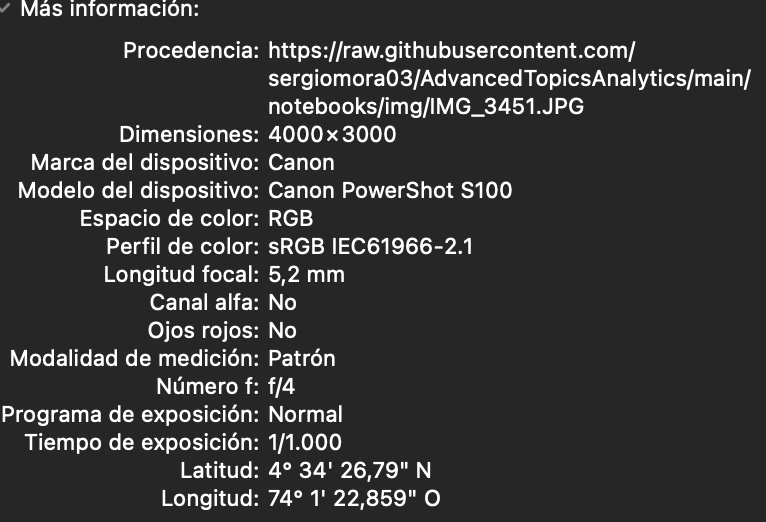

Output:
1. probability that it is a Big Monk.
2. Calculate Big Monks density

## Evaluation

- 30% Report with all the details of the solution, the analysis and the conclusions. The report cannot exceed 10 pages, must be send in PDF format and must be self-contained.
- 30% Code with the data processing and models developed that support the reported results.
- 30% Presentation of no more than 15 minutes with the main results of the project.
- 10% Model performance achieved. Metric: "AUC".


## Requirements

- The project must be carried out in groups of 4 people.
- Use clear and rigorous procedures.
- The delivery of the project is on September 6th, 2024, 11:59 pm, through email with Github link.
- No projects will be received after the delivery time or by any other means than the one established.

## Suggestions

* Use an hyperparameter optimization framework, you can also make grid optimziation or bayesian optimization. Bonus with use:  [Optuna - A hyperparameter optimization framework](https://optuna.org/)
* Remember cualitative analysis with validation image: `IMG_3451.JPG`
* Estimate density for each Big Monks population detected. Bonus with: [Gaussian Mixture Models](https://nbviewer.jupyter.org/github/sergiomora03/Gaussian_Mixture_Models/blob/master/intro_to_gmm_%26_em.ipynb)

## Acknowledgements
We thank Professor Camilo Franco, Ph.D.

In [1]:
pip install tensorflow

In [2]:
pip install livelossplot

In [3]:
pip install scikeras

In [7]:
import numpy as np
import h5py
import random
import urllib
from functools import partial
import matplotlib.pyplot as plt
import sklearn
import sklearn.datasets
import sklearn.linear_model
from sklearn.model_selection import train_test_split

import os
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import load_img # import load_img from the correct module

import tensorflow as tf
import keras
from keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Flatten
from sklearn.metrics import roc_auc_score
from tensorflow.keras.regularizers import l1_l2, l2
from tensorflow.keras.optimizers import Adam
from livelossplot import PlotLossesKeras
from tensorflow.keras.layers import Dense, Activation, Dropout, BatchNormalization
from scikeras.wrappers import KerasClassifier
#from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
#from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

%matplotlib inline

## Conjunto de datos

Para el entrenamiento de la red neuronal, se usará el archivo `data_F`. Debe divirse en dos grupos, conjunto de entrenamiento (CE) y conjunto de validación (CV).

Adicionalmente, fuera de las métricas del modelo, se requiere que extraiga un análisis cualitativo con la imagen `IMG_3451.JPG`, donde muestre los Frilejones detectados en el area del páramo tomado por la fotografía.

Recuerde, primero, cargamos el conjunto de datos sobre el que se va a trabajar. El siguiente código va a cargar un conjunto de datos `X` e `Y` donde `Y`es una variable binaria.

## Caso Aplicado

### Cálculo de cantidad de Frilejones

vamos a aplicar al menos 5 modelos, se estiman los siguientes valores como resultado del entrenamiento:



*   Sencilla --> 0.88
*   Multi-capa --> 0.95
*  Convolucional --> 0.95
*  Convolucional + VGG16 --> 0.99



In [2]:
urllib.request.urlretrieve(
    'https://raw.githubusercontent.com/sergiomora03/AdvancedTopicsAnalytics/main/notebooks/img/ImportImagenesURL.py',
    'ImportImagenes.py'
  )

('ImportImagenes.py', <http.client.HTTPMessage at 0x17fc2a510>)

In [3]:
from ImportImagenes import *

In [4]:
X,Y = import_imagenes()

In [5]:
X,Y = import_imagenes()

CE_x, CV_x, CE_y, CV_y = train_test_split(X.T, Y.T, test_size = 0.3, random_state = 100)

CE_x = CE_x.T
CV_x = CV_x.T
CE_y = CE_y.T
CV_y = CV_y.T

n=CE_y.shape[1]
m=CV_y.shape[1]

print("Atributos Entrenamiento:", CE_x.shape,'\n', "Atributos Validación:",CV_x.shape,'\n',"Clase Entrenamiento:",CE_y.shape,'\n',"Clase Validación:", CV_y.shape)

Atributos Entrenamiento: (14700, 175) 
 Atributos Validación: (14700, 75) 
 Clase Entrenamiento: (1, 175) 
 Clase Validación: (1, 75)


## 1. Implementa una red neuronal sencilla.

In [8]:
# Rango de neuronas para la capa oculta
num_neuronas = np.arange(8, 64, 8)

# Fijar la semilla para reproducibilidad
SEED = 63
tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

# Directorio para guardar los modelos
checkpoint_dir = './checkpoints/'
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)

# Para almacenar los resultados de cada modelo
resultados = []

for i, n_h in enumerate(num_neuronas):
    model = Sequential()
    # Capa oculta con 'relu' y dropout
    model.add(Dense(
        n_h,
        input_dim=14700,
        activation='relu',
        kernel_initializer=tf.keras.initializers.GlorotUniform(seed=SEED),
        bias_initializer=tf.keras.initializers.Zeros()))
    
    # Añadir Dropout para prevenir sobreajuste
    model.add(Dropout(0.5))  # Dropout con probabilidad de 50%

    # Capa de salida
    model.add(Dense(1, activation='sigmoid'))

    # Compilar el modelo, solo AUC como métrica
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['AUC'])

    # Definir un callback para guardar el modelo con el mejor AUC en validación
    checkpoint_path = f"{checkpoint_dir}best_model_{n_h}_neurons.keras"
    checkpoint = ModelCheckpoint(
        checkpoint_path, 
        monitor='val_AUC',  # Monitorear AUC en validación
        save_best_only=True,  # Guardar solo el mejor modelo
        mode='max',  # Queremos maximizar AUC
        verbose=1
    )

    # Entrenamiento del modelo con validación y el callback
    history = model.fit(CE_x.T, CE_y.T, 
                        epochs=8, 
                        validation_data=(CV_x.T, CV_y.T), 
                        callbacks=[checkpoint],  # Incluir el callback
                        verbose=1)  # Cambiado a 1 para ver el progreso

    # Cargar el mejor modelo basado en el AUC de validación
    model.load_weights(checkpoint_path)

    # Evaluar el modelo en el conjunto de validación
    test_loss, test_auc = model.evaluate(CV_x.T, CV_y.T, verbose=1)  # Solo AUC
    print(f'Numero de neuronas = {n_h}')
    print(f'Test AUC: {test_auc}')
    
    # Guardar los resultados
    resultados.append({'neuronas': n_h, 'test_auc': test_auc, 'mejor_modelo': checkpoint_path})

# Mostrar los resultados
for res in resultados:
    print(f"Neurona: {res['neuronas']} -> Test AUC: {res['test_auc']}, Guardado en: {res['mejor_modelo']}")


Epoch 1/8


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/6 ━━━━━━━━━━━━━━━━━━━━ 1s 354ms/step - AUC: 0.6275 - loss: 0.7494
Epoch 1: val_AUC improved from -inf to 0.50000, saving model to ./checkpoints/best_model_8_neurons.keras
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - AUC: 0.6005 - loss: 1.2119 - val_AUC: 0.5000 - val_loss: 0.6931
Epoch 2/8
1/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - AUC: 0.5000 - loss: 0.6931
Epoch 2: val_AUC did not improve from 0.50000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.5000 - loss: 0.6931 - val_AUC: 0.5000 - val_loss: 0.6930
Epoch 3/8
1/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - AUC: 0.5000 - loss: 0.6929
Epoch 3: val_AUC did not improve from 0.50000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.5000 - loss: 0.6929 - val_AUC: 0.5000 - val_loss: 0.6928
Epoch 4/8
1/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - AUC: 0.5000 - loss: 0.6927
Epoch 4: val_AUC did not improve from 0.50000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.5000 - loss: 0.6926 - val_AUC: 0.5000 - val_loss: 0.6925
Epoch 5/8
1/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/ste

In [9]:
# Cargue del mejor modelo
best_model_path = './checkpoints/best_model_32_neurons.keras'

single_NN = tf.keras.models.load_model(best_model_path, custom_objects={'AUC': tf.keras.metrics.AUC()})

In [10]:
# Cargue de la imagen para prueba cualitativa
urllib.request.urlretrieve('https://github.com/sergiomora03/AdvancedTopicsAnalytics/blob/main/notebooks/img/IMG_3451.JPG?raw=true', 'IMG_3451.JPG')
img = load_img('IMG_3451.JPG')

118


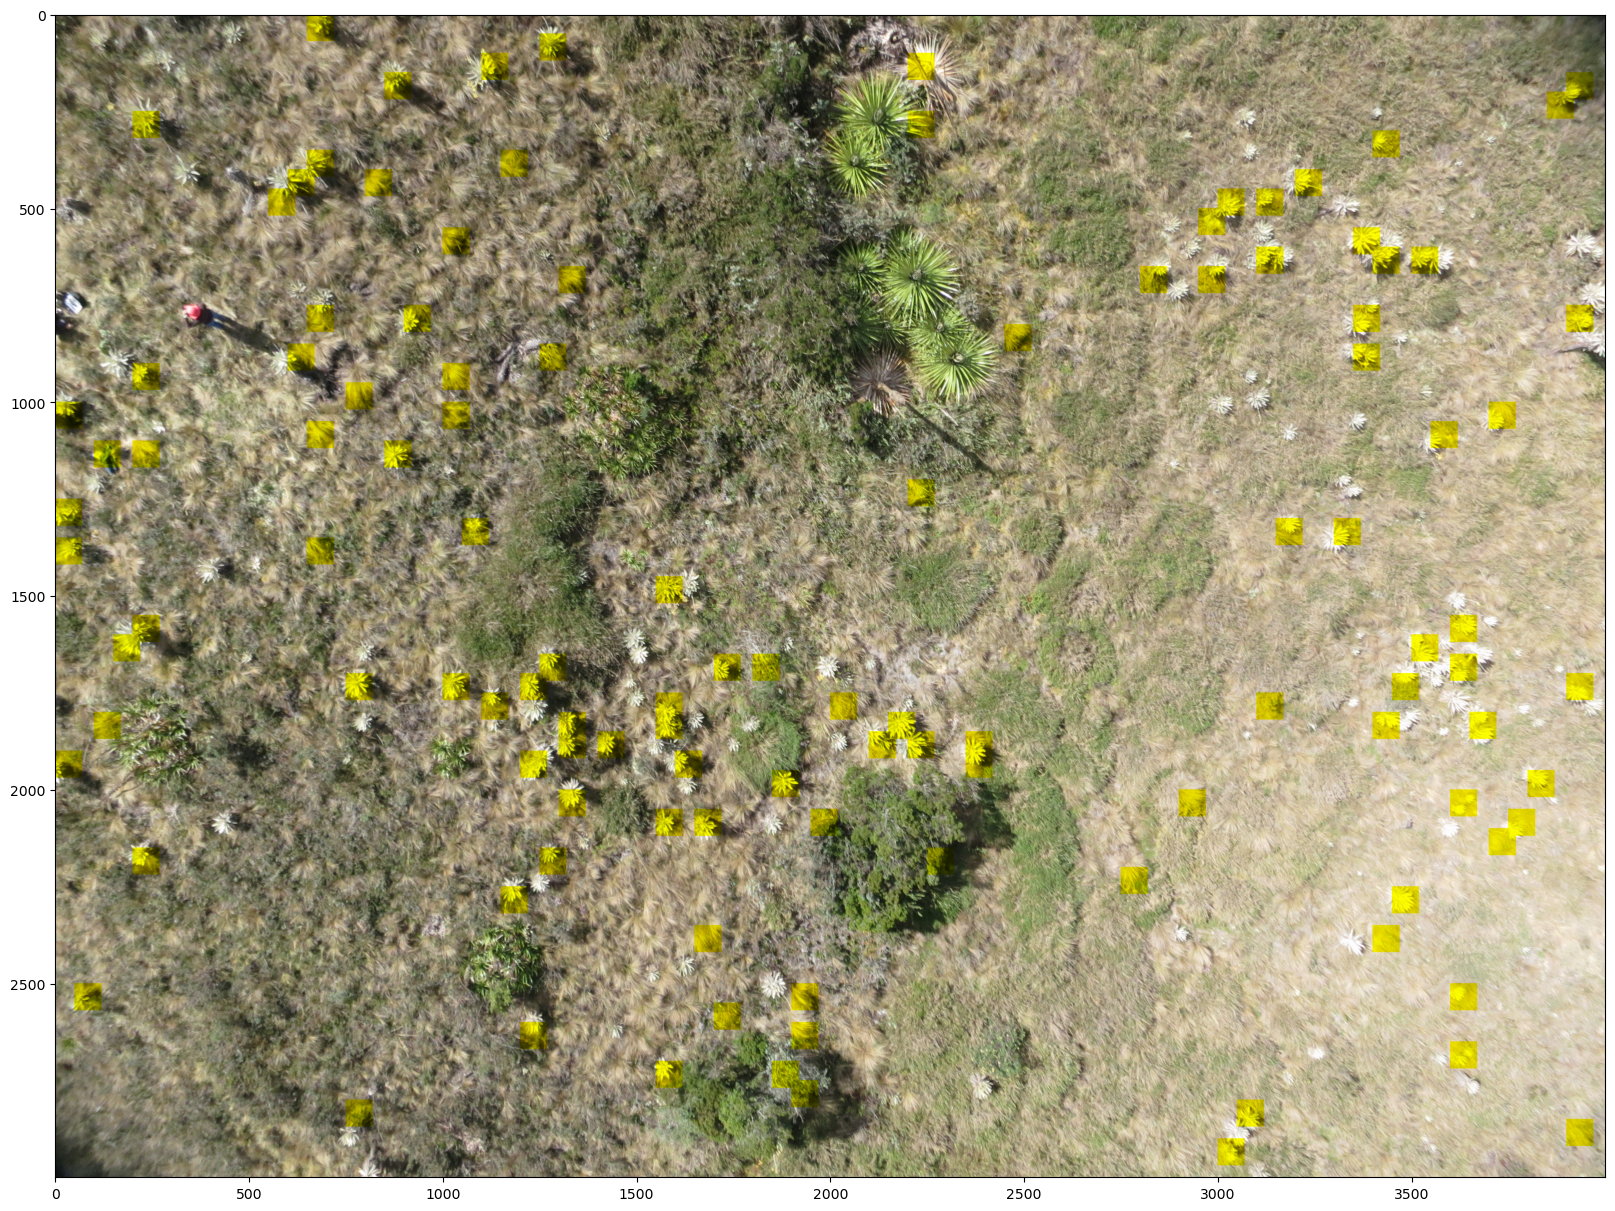

In [16]:
# Prueba cualitativa con red neuronal sencilla
x = np.array(img)
x2 = x
cont = 0

ni = x.shape[0]-50
mi = x.shape[1]-50

a = []

f1=0
f2=70
for i in range(1,ni,50):
    c1=0
    c2=70
    for j in range(1,mi,50):
        subi=x[f1:f2,c1:c2,]
        subi2=np.ndarray.flatten(subi).T/255.
        ns=subi2.shape[0]
        vec=subi2
        vec.shape=(1,ns)
        #vec.shape=(ns,)
        #vec.shape=(ns,)
        single_NN(vec)
        
        #pred_P=pred(param, vec)
        if(single_NN(vec)[[0,0]]>0.75):
            x2[f1:f2,c1:c2,2]=0
            cont = cont + 1
        c1=c1+50
        c2=c2+50
    f1=f1+50
    f2=f2+50

plt.figure(figsize = (20,20))
plt.imshow(x2)

print(cont)



## 2. Implementa una red neuronal multi-capa


In [5]:
def import_imagenes2():

    urllib.request.urlretrieve("https://github.com/sergiomora03/AdvancedTopicsAnalytics/raw/main/datasets/data_F", "data_F")
    FF = h5py.File('data_F','r')

    CTF = FF.get('Frailejon')
    fraile = np.array(CTF)

    CTNF = FF.get('NoFrailejon')
    nofraile = np.array(CTNF)

    # Tomamos el numero de ejemplos para cada clase
    n = fraile.shape[0]
    m = nofraile.shape[0]

    # Inicializamos los arreglos donde vamos a guardar los ejemplos de cada clase
    fraile2 = []
    nofraile2 = []

    r = m

    for l in range(2):
        if(l==1):
            r = n
        for i in range(0,r,1):
            for j in range(0,5,1):
                if (j==0):
                    r1=0
                    c1=0
                    r2=70
                    c2=70
                    if(l==0):
                        x = nofraile[i,r1:r2,c1:c2,]
                        nofraile2.append(x)
                    if(l==1):
                        x = fraile[i,r1:r2,c1:c2,]
                        fraile2.append(x)
                if (j==1):
                    r1=r1+30
                    r2=r2+30
                    if(l==0):
                        x = nofraile[i,r1:r2,c1:c2,]
                        nofraile2.append(x)
                    if(l==1):
                        x = fraile[i,r1:r2,c1:c2,]
                        fraile2.append(x)
                if(j==2):
                    c1=c1+30
                    c2=c2+30
                    if(l==0):
                        x = nofraile[i,r1:r2,c1:c2,]
                        nofraile2.append(x)
                    if(l==1):
                        x = fraile[i,r1:r2,c1:c2,]
                        fraile2.append(x)
                if(j==3):
                    r1=0
                    r2=70
                    if(l==0):
                        x = nofraile[i,r1:r2,c1:c2,]
                        nofraile2.append(x)
                    if(l==1):
                        x = fraile[i,r1:r2,c1:c2,]
                        fraile2.append(x)
                if(j==4):
                    r1=15
                    c1=15
                    r2=85
                    c2=85
                    if(l==0):
                        x = nofraile[i,r1:r2,c1:c2,]
                        nofraile2.append(x)
                    if(l==1):
                        x = fraile[i,r1:r2,c1:c2,]
                        fraile2.append(x)

    nofraile2=np.asarray(nofraile2)
    fraile2=np.asarray(fraile2)

    CT_x2=np.concatenate((fraile2,nofraile2))

    CT_y = ([1]*np.array(fraile2).shape[0]+[0]*np.array(nofraile2).shape[0])
    CT_y = np.vstack( CT_y ).T

    return CT_x2,CT_y

In [6]:
# Cargue de las imagenes previo a aplanarlas
images_CNN_X, images_CNN_y = import_imagenes2()
print(images_CNN_X.shape)
print(images_CNN_y.shape)

(250, 70, 70, 3)
(1, 250)


In [7]:
images_CNN_X = tf.keras.layers.CenterCrop(height=70, width=70)(images_CNN_X)
images_CNN_X = tf.keras.layers.Rescaling(scale=1 / 255)(images_CNN_X)

In [8]:
# Convert the TensorFlow tensor to a NumPy array
images_CNN_X_np = images_CNN_X.numpy()

In [20]:
# 1. Data Augmentation
data_gen = ImageDataGenerator(
    rotation_range=20,            # Rotate images up to 20 degrees
    width_shift_range=0.2,        # Shift width up to 20%
    height_shift_range=0.2,       # Shift height up to 20%
    shear_range=0.2,              # Shear up to 20%
    zoom_range=0.2,               # Zoom up to 20%
    horizontal_flip=True,         # Flip images horizontally
    fill_mode='nearest'           # Fill mode for newly created pixels after augmentation
)

In [21]:
CNN_CE_x, CNN_CV_x, CNN_CE_y, CNN_CV_y = train_test_split(images_CNN_X_np, images_CNN_y.T, test_size = 0.3, random_state = 100)
print("Atributos Entrenamiento:", CNN_CE_x.shape,'\n', "Atributos Validación:", CNN_CV_x.shape, '\n',"Clase Entrenamiento:", CNN_CE_y.shape, '\n',"Clase Validación:", CNN_CV_y.shape)

Atributos Entrenamiento: (175, 70, 70, 3) 
 Atributos Validación: (75, 70, 70, 3) 
 Clase Entrenamiento: (175, 1) 
 Clase Validación: (75, 1)


In [47]:
# Fit the data augmentation generator on the training data
train_generator = data_gen.flow(CNN_CE_x, CNN_CE_y, batch_size=32)

In [56]:
SEED = 30
tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

model = Sequential()
model.add(Flatten(input_shape=[70, 70, 3]))
model.add(Dense(
    4092,
    activation='relu',
    #kernel_initializer='he_normal',
    #kernel_regularizer=l2(0.01),
    kernel_initializer=tf.keras.initializers.GlorotUniform(seed=SEED),  # Semilla para la inicialización de pesos
    bias_initializer=tf.keras.initializers.Zeros()))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(
    2048,
    activation='relu',
    #kernel_initializer='he_normal',
    #kernel_regularizer=l2(0.01),
    kernel_initializer=tf.keras.initializers.GlorotUniform(seed=SEED),  # Semilla para la inicialización de pesos
    bias_initializer=tf.keras.initializers.Zeros()))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(
    1024,
    activation='relu',
    #kernel_initializer='he_normal',
    #kernel_regularizer=l2(0.01),
    kernel_initializer=tf.keras.initializers.GlorotUniform(seed=SEED),  # Semilla para la inicialización de pesos
    bias_initializer=tf.keras.initializers.Zeros()))
model.add(BatchNormalization())
model.add(Dropout(0.4))
model.add(Dense(
    512,
    activation='relu',
    #kernel_initializer='he_normal',
    #kernel_regularizer=l1_l2(l1=0.001, l2=0.001),
    kernel_initializer=tf.keras.initializers.GlorotUniform(seed=SEED),  # Semilla para la inicialización de pesos
    bias_initializer=tf.keras.initializers.Zeros()))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(
    256,
    activation='relu',
    #kernel_initializer='he_normal',
    #kernel_regularizer=l1_l2(l1=0.001, l2=0.001),
    kernel_initializer=tf.keras.initializers.GlorotUniform(seed=SEED),  # Semilla para la inicialización de pesos
    bias_initializer=tf.keras.initializers.Zeros()))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(
    128,
    activation='relu',
    #kernel_initializer='he_normal',
    #kernel_regularizer=l1_l2(l1=0.001, l2=0.001),
    kernel_initializer=tf.keras.initializers.GlorotUniform(seed=SEED),  # Semilla para la inicialización de pesos
    bias_initializer=tf.keras.initializers.Zeros()))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(
    64,
    activation='relu',
    #kernel_initializer='he_normal',
    #kernel_regularizer=l1_l2(l1=0.001, l2=0.001),
    kernel_initializer=tf.keras.initializers.GlorotUniform(seed=SEED),  # Semilla para la inicialización de pesos
    bias_initializer=tf.keras.initializers.Zeros()))
model.add(BatchNormalization())
model.add(Dropout(0.1))
model.add(Dense(
    32,
    activation='relu',
    #kernel_initializer='he_normal',
    #kernel_regularizer=l1_l2(l1=0.001, l2=0.001),
    kernel_initializer=tf.keras.initializers.GlorotUniform(seed=SEED),  # Semilla para la inicialización de pesos
    bias_initializer=tf.keras.initializers.Zeros()))
#model.add(BatchNormalization())
#model.add(Dropout(0.5))
model.add(Dense(
    16,
    activation='relu',
    #kernel_initializer='he_normal',
    #kernel_regularizer=l1_l2(l1=0.001, l2=0.001),
    kernel_initializer=tf.keras.initializers.GlorotUniform(seed=SEED),  # Semilla para la inicialización de pesos
    bias_initializer=tf.keras.initializers.Zeros()))
#model.add(BatchNormalization())
#model.add(Dropout(0.5))
model.add(Dense(
    8,
    activation='relu',
    #kernel_initializer='he_normal',
    #kernel_regularizer=l1_l2(l1=0.001, l2=0.001),
    kernel_initializer=tf.keras.initializers.GlorotUniform(seed=SEED),  # Semilla para la inicialización de pesos
    bias_initializer=tf.keras.initializers.Zeros()))
#model.add(BatchNormalization())
#model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

In [57]:
model.summary()

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten_10 (Flatten)                 │ (None, 14700)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_109 (Dense)                    │ (None, 4092)                │      60,156,492 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_37               │ (None, 4092)                │          16,368 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_35 (Dropout)                 │ (None, 4092)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_110 (Dense)                    │ (None, 2048)                │       8,382,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_38               │ (None, 2048)                │           8,192 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_36 (Dropout)                 │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_111 (Dense)                    │ (None, 1024)                │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_39               │ (None, 1024)                │           4,096 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_37 (Dropout)                 │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_112 (Dense)                    │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_40               │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_38 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_113 (Dense)                    │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_41               │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_39 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_114 (Dense)                    │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_42               │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 71,369,661 (272.25 MB)

 Trainable params: 71,353,413 (272.19 MB)

 Non-trainable params: 16,248 (63.47 KB)

In [58]:
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['AUC'])

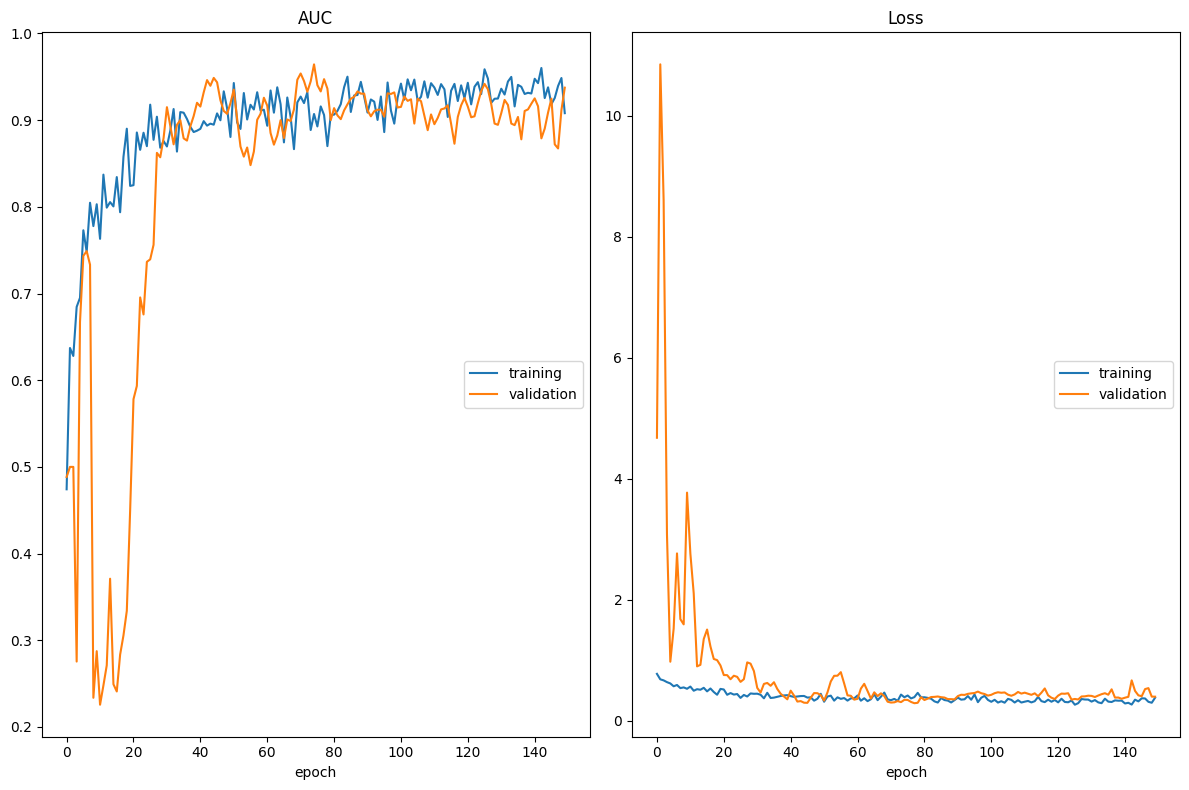

AUC
	training         	 (min:    0.474, max:    0.960, cur:    0.908)
	validation       	 (min:    0.226, max:    0.964, cur:    0.938)
Loss
	training         	 (min:    0.262, max:    0.772, cur:    0.378)
	validation       	 (min:    0.287, max:   10.847, cur:    0.395)
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step - AUC: 0.9256 - loss: 0.3462 - val_AUC: 0.9375 - val_loss: 0.3949


In [59]:
monks_model = model.fit(
    train_generator,
    validation_data=[CNN_CV_x, CNN_CV_y],
    epochs=150, verbose=1,
    callbacks=[PlotLossesKeras()])

In [ ]:
# Fijar la semilla para reproducibilidad
SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)

# Función para crear el modelo
def create_model(num_layers=1, num_neurons=32, dropout_rate=0.3):
    model = Sequential()
    model.add(Dense(num_neurons, input_dim=14700, activation='relu', kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))

    for _ in range(num_layers - 1):
        model.add(Dense(num_neurons, activation='relu', kernel_initializer='he_normal'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout_rate))

    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['AUC'])
    return model

# Envuelve el modelo con KerasClassifier
model = KerasClassifier(model=create_model, epochs=10, batch_size=32, verbose=0)

# Define los parámetros para el Grid Search
param_grid = {
    'model__num_layers': [2, 3, 4, 5],
    'model__num_neurons': [64, 128, 256, 512],
    'model__dropout_rate': [0.1, 0.2, 0.3, 0.4]
}

# Configura el Grid Search
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, verbose=0, n_jobs=-1)

# Asumiendo que x_train y y_train son tus datos de entrenamiento
# x_train, y_train = ... # Carga o define tus datos aquí

# Entrena el modelo
grid_result = grid.fit(CE_x.T, CE_y.T)

# Imprime los resultados
print(f"Mejor resultado: {grid_result.best_score_} con parámetros: {grid_result.best_params_}")


## 3. Implementa una red neuronal convolucional

In [ ]:
#tf.random.set_seed(78)  # extra code – ensures reproducibility
# Fijar la semilla para reproducibilidad
SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)

# DRop 0.5 => 94,8 AUC test
model_CNN = tf.keras.Sequential([
    tf.keras.layers.Conv2D(
        filters = 32,
        kernel_size = 7,
        padding='same',
        strides=2,
        activation='relu',
        kernel_initializer="he_normal",
        input_shape=[70, 70, 3]),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(
        filters=64,
        kernel_size = 7,
        padding='same',
        strides=2,
        activation='relu',
        kernel_initializer="he_normal"),
    #DefaultConv2D(filters=128),
    tf.keras.layers.MaxPool2D(),
    #DefaultConv2D(filters=256),
    #DefaultConv2D(filters=256),
    #tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=1024, activation="relu",
                          kernel_initializer="he_normal"),
    #model.add(BatchNormalization())
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(units=512, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(units=64, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.BatchNormalization(),
    #tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(units=1, activation="sigmoid")
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model_CNN.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['AUC'])

#history = model.fit(CNN_CE_x, CNN_CE_y, epochs=10,
#                    validation_data=(CNN_CV_x, CNN_CV_y))
#score = model.evaluate(CNN_CV_x, CNN_CV_y)

In [ ]:
model_CNN.summary()

Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_25 (Conv2D)              │ (None, 35, 35, 32)     │         4,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 17, 17, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 9, 9, 64)       │       100,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_10 (Flatten)            │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_53 (Dense)                │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_21          │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_54 (Dense)                │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_22          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_55 (Dense)                │ (None, 64)             │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_23          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_56 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,718,849 (6.56 MB)

 Trainable params: 1,715,649 (6.54 MB)

 Non-trainable params: 3,200 (12.50 KB)

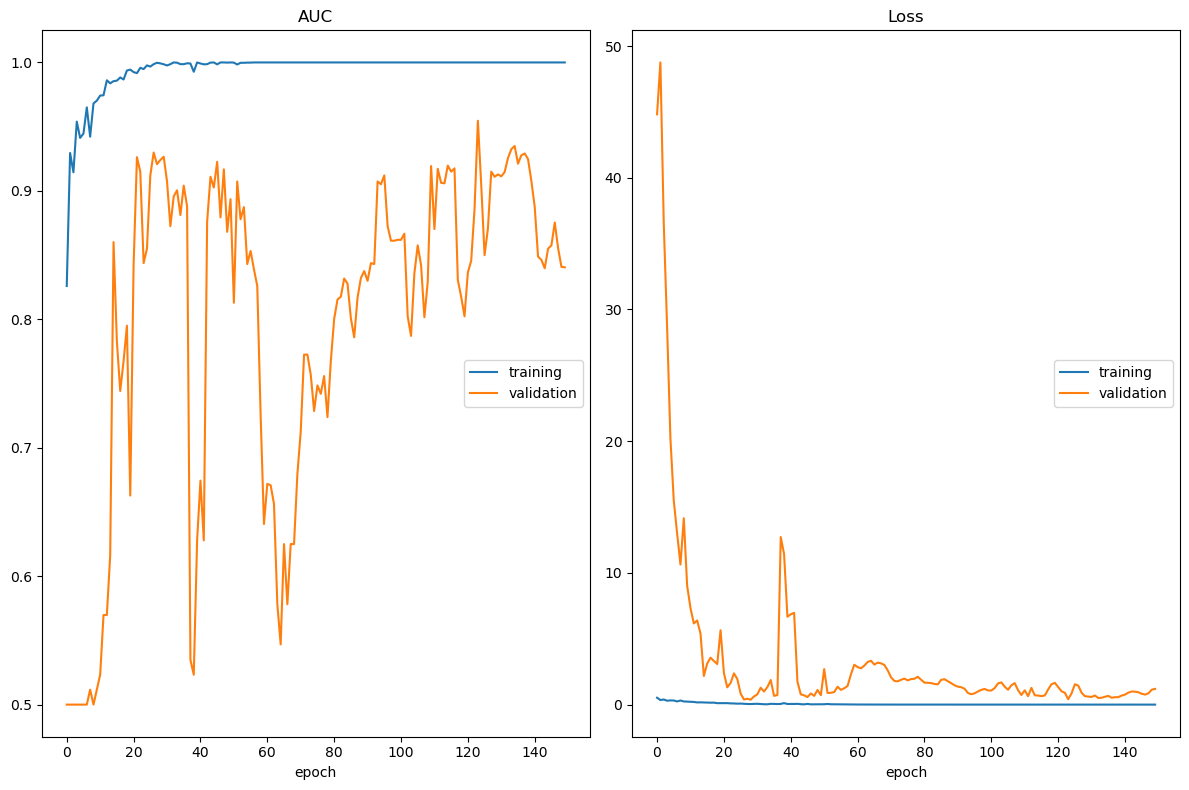

AUC
	training         	 (min:    0.826, max:    1.000, cur:    1.000)
	validation       	 (min:    0.500, max:    0.955, cur:    0.840)
Loss
	training         	 (min:    0.001, max:    0.524, cur:    0.001)
	validation       	 (min:    0.373, max:   48.757, cur:    1.193)
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - AUC: 1.0000 - loss: 5.0879e-04 - val_AUC: 0.8405 - val_loss: 1.1933


In [ ]:
monks_model_CNN = model_CNN.fit(
    CNN_CE_x, CNN_CE_y,
    validation_data=[CNN_CV_x, CNN_CV_y],
    epochs=150, verbose=1,
    callbacks=[PlotLossesKeras()])

In [ ]:
# extra code – this utility function can be useful to compute the size of the
#              feature maps output by a convolutional layer. It also returns
#              the number of ignored rows or columns if padding="valid", or the
#              number of zero-padded rows or columns if padding="same"."""

import numpy as np

def conv_output_size(input_size, kernel_size, strides=1, padding="valid"):
    if padding=="valid":
        z = input_size - kernel_size + strides
        output_size = z // strides
        num_ignored = z % strides
        return output_size, num_ignored
    else:
        output_size = (input_size - 1) // strides + 1
        num_padded = (output_size - 1) * strides + kernel_size - input_size
        return output_size, num_padded

conv_output_size(np.array([70, 70]), kernel_size=7, strides=2, padding="same")

(array([35, 35]), array([5, 5]))

In [ ]:
max_pool = tf.keras.layers.MaxPool2D(pool_size=2)

In [ ]:
output = max_pool(fmaps)

In [ ]:
output.shape

TensorShape([250, 17, 17, 32])





## 4. Implementa una red neuronal convolucional con tranferencia VGG-16



In [6]:
# Cargue de las imagenes previo a aplanarlas
images_CNN_VGG16_X, images_CNN_VGG16_y = import_imagenes2()
print(images_CNN_VGG16_X.shape)
print(images_CNN_VGG16_y.shape)

(250, 70, 70, 3)
(1, 250)


In [7]:
# Reescalado
images_CNN_VGG16_X = tf.keras.layers.Rescaling(scale=1 / 255)(images_CNN_VGG16_X)
#
images_resized = []
for image in images_CNN_VGG16_X:
  resized_image = tf.keras.layers.Resizing(height=224, width=224,
                                          crop_to_aspect_ratio=True)(image)
  images_resized.append(resized_image)

In [8]:
images_resized = tf.convert_to_tensor(images_resized)
images_resized = images_resized.numpy()

In [9]:
CNN_VGG16_CE_x, CNN_VGG16_CV_x, CNN_VGG16_CE_y, CNN_VGG16_CV_y = train_test_split(images_resized, images_CNN_VGG16_y.T, test_size = 0.3, random_state = 100)
print("Atributos Entrenamiento:",CNN_VGG16_CE_x.shape,'\n', "Atributos Validación:",CNN_VGG16_CV_x.shape,'\n',"Clase Entrenamiento:", CNN_VGG16_CE_y.shape,'\n',"Clase Validación:", CNN_VGG16_CV_y.shape)

Atributos Entrenamiento: (175, 224, 224, 3) 
 Atributos Validación: (75, 224, 224, 3) 
 Clase Entrenamiento: (175, 1) 
 Clase Validación: (75, 1)


In [12]:
data_gen_2 = ImageDataGenerator(
    rotation_range=20,            # Rotate images up to 20 degrees
    zoom_range=0.2,               # Zoom up to 20%
    horizontal_flip=True,         # Flip images horizontally
    fill_mode='nearest'           # Fill mode for newly created pixels after augmentation
)

In [13]:
# Fit the data augmentation generator on the training data
train_generator_VGG16 = data_gen_2.flow(CNN_VGG16_CE_x, CNN_VGG16_CE_y, batch_size=32)

In [14]:
import tensorflow as tf
import numpy as np
import random
from tensorflow.keras import layers, models
from tensorflow.keras.applications import VGG16

In [15]:
def set_seed(seed_value=42):
    np.random.seed(seed_value)
    random.seed(seed_value)
    tf.random.set_seed(seed_value)

# Llamar a la función para establecer las semillas
set_seed(42)

In [16]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Congelar las capas del modelo base para que no se entrenen
for layer in base_model.layers:
    layer.trainable = False

# Crear el modelo secuencial
model = models.Sequential()

# Añadir el modelo base VGG16
model.add(base_model)

# Aplanar la salida de VGG16 para conectar con las capas densas
model.add(layers.Flatten())

# Añadir una capa densa
model.add(layers.Dense(1024, activation='relu'))

# Añadir una capa para estabilizar la optimización
#model.add(BatchNormalization())

# Añadir dropout para evitar el sobreajuste
#model.add(layers.Dropout(0.7))

# Añadir una capa densa
#model.add(layers.Dense(512, activation='relu'))

# Añadir dropout para evitar el sobreajuste
#model.add(layers.Dropout(0.6))

# Añadir una capa densa
#model.add(layers.Dense(256, activation='relu'))

# Añadir dropout para evitar el sobreajuste
#model.add(layers.Dropout(0.5))

# Añadir una capa densa
#model.add(layers.Dense(128, activation='relu'))

# Añadir dropout para evitar el sobreajuste
#model.add(layers.Dropout(0.3))

# Capa de salida con activación sigmoid para la clasificación binaria
model.add(layers.Dense(1, activation='sigmoid'))

In [17]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['AUC'])

In [18]:
# Add a dummy input
dummy_input = np.random.rand(1, 224, 224, 3) # Example with batch size of 1

# Call predict to force the model to build and infer shapes
model.predict(dummy_input)

# Now you can safely call summary
model.summary()

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (1, 7, 7, 512)              │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (1, 25088)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (1, 1024)                   │      25,691,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (1, 1)                      │           1,025 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 40,406,849 (154.14 MB)

 Trainable params: 25,692,161 (98.01 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

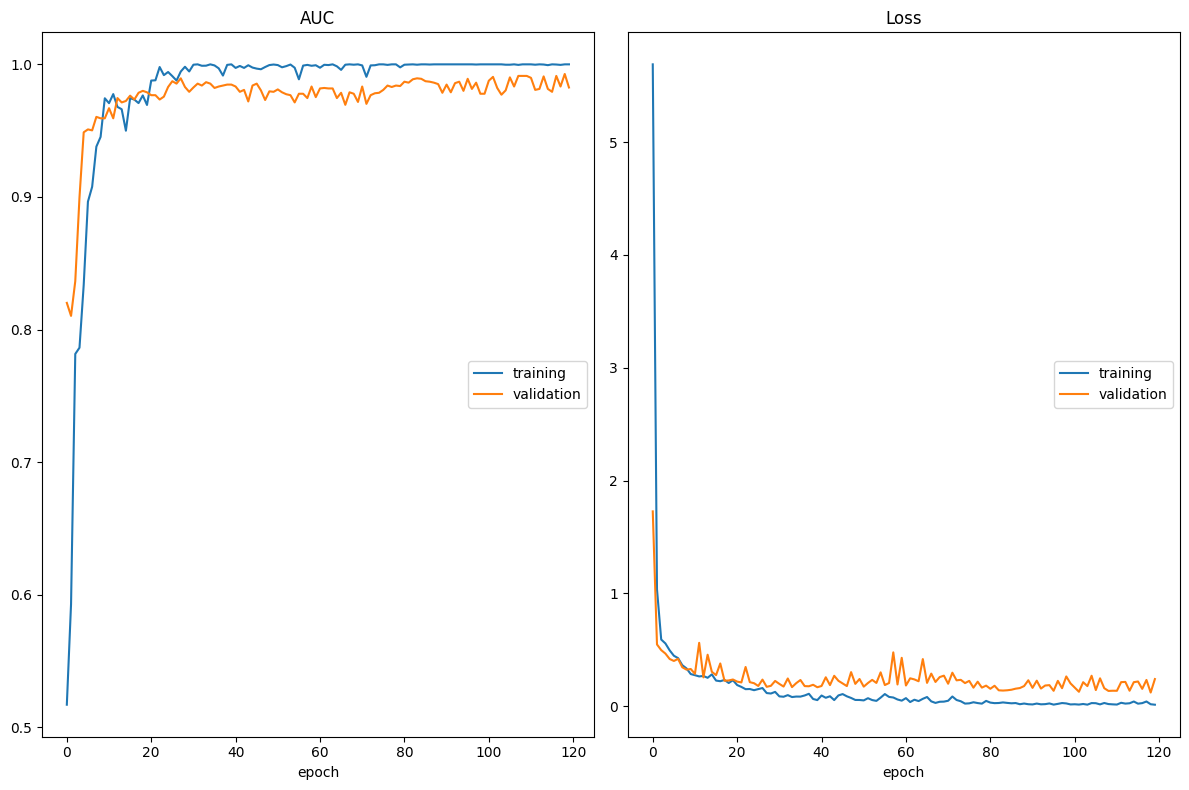

AUC
	training         	 (min:    0.517, max:    1.000, cur:    1.000)
	validation       	 (min:    0.810, max:    0.993, cur:    0.983)
Loss
	training         	 (min:    0.013, max:    5.690, cur:    0.013)
	validation       	 (min:    0.121, max:    1.727, cur:    0.240)
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 270ms/step - AUC: 1.0000 - loss: 0.0115 - val_AUC: 0.9826 - val_loss: 0.2399


In [19]:
monks_model_CNN_VGG16 = model.fit(
    train_generator_VGG16,
    validation_data=[CNN_VGG16_CV_x, CNN_VGG16_CV_y],
    epochs=120, verbose=1,
    callbacks=[PlotLossesKeras()])

qsdfqsdf

In [ ]:
model_CNN_VGG16 = tf.keras.applications.VGG16(weights="imagenet")

In [ ]:
model_CNN_VGG16.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ predictions (Dense)             │ (None, 1000)           │     4,097,000 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 138,357,544 (527.79 MB)

 Trainable params: 138,357,544 (527.79 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
inputs = tf.keras.applications.vgg16.preprocess_input(CNN_VGG16_CE_x)

In [ ]:
inputs.shape

(175, 224, 224, 3)

In [ ]:
Y_proba = model_CNN_VGG16.predict(inputs)
Y_proba.shape

6/6 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step


(175, 1000)

In [ ]:
model_CNN_VGG16 = tf.keras.Sequential([
    tf.keras.applications.VGG16(weights="imagenet"),
    tf.keras.layers.Dense(units=1024, activation="relu",
                          kernel_initializer="he_normal"),
    #model.add(BatchNormalization())
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(units=512, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(units=64, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.BatchNormalization(),
    #tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(units=1, activation="sigmoid")
])

In [ ]:
model_CNN_VGG16.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['AUC'])

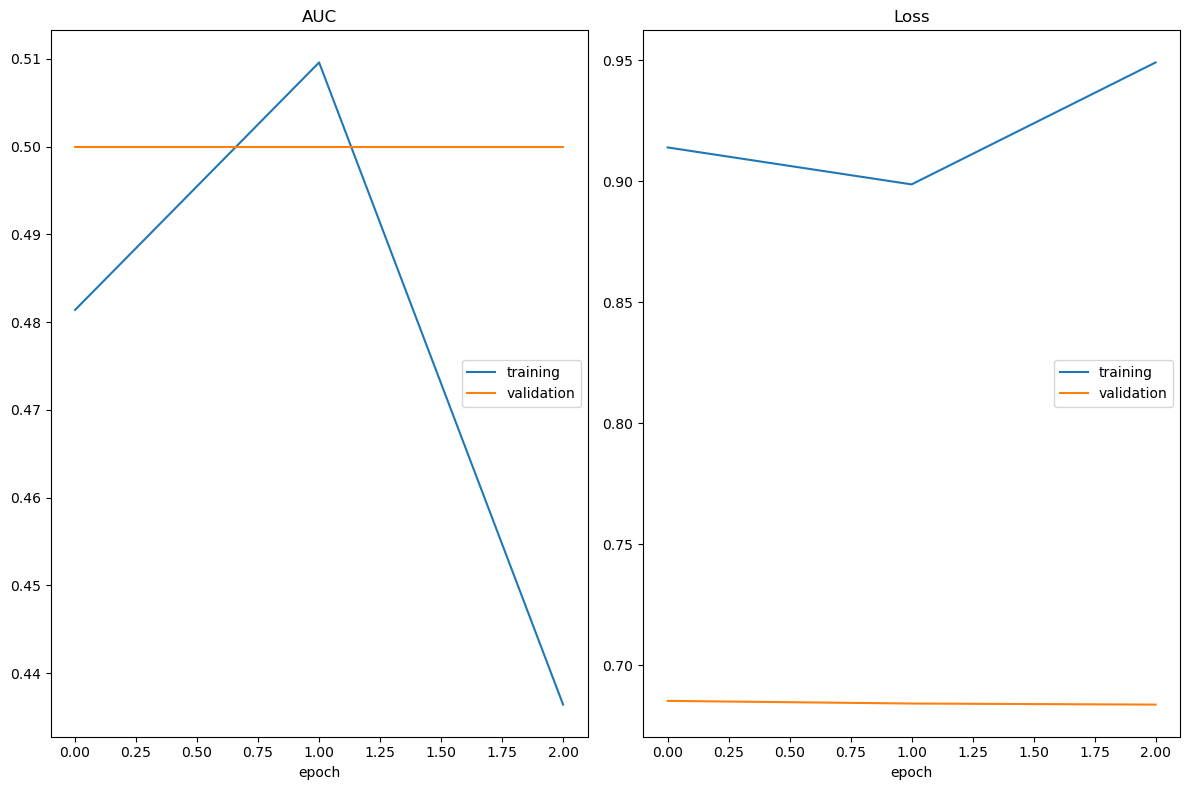

AUC
	training         	 (min:    0.436, max:    0.510, cur:    0.436)
	validation       	 (min:    0.500, max:    0.500, cur:    0.500)
Loss
	training         	 (min:    0.899, max:    0.949, cur:    0.949)
	validation       	 (min:    0.684, max:    0.685, cur:    0.684)
6/6 ━━━━━━━━━━━━━━━━━━━━ 81s 14s/step - AUC: 0.4712 - loss: 0.9213 - val_AUC: 0.5000 - val_loss: 0.6837


In [ ]:
monks_model_CNN_VGG16 = model_CNN_VGG16.fit(
    CNN_VGG16_CE_x, CNN_VGG16_CE_y,
    validation_data=[CNN_VGG16_CV_x, CNN_VGG16_CV_y],
    epochs=3, verbose=1,
    callbacks=[PlotLossesKeras()])

## 5. Implementa una red neuronal convolucional con tranferencia VGG-16 y ajuste de hiperparámetros (bono por uso de Optuna).




## 6. Responda: **¿Qué puede observar sobre el desempeño de los diferentes modelos? Argumente cuál es el mejor modelo para poner en producción.**

Ver informe CRISP

## 7. Investigue otra red pre-entrenada dsitinta a la VGG-16 e implemente el aprendizaje por transferencia para la deteccion de frailejones. Argumente por qué su justifica el aprendizaje por transferencia con base en el modelo pre-entrenado de su elección (cómo se relacionan la tarea base y la segunda tarea objetivo).

In [6]:
# Cargue de las imagenes previo a aplanarlas
images_CNN_ResNet_X, images_CNN_ResNet_y = import_imagenes2()
print(images_CNN_ResNet_X.shape)
print(images_CNN_ResNet_y.shape)

(250, 70, 70, 3)
(1, 250)


In [7]:
# Reescalado
images_CNN_ResNet_X = tf.keras.layers.Rescaling(scale=1 / 255)(images_CNN_ResNet_X)
#
images_resized = []
for image in images_CNN_ResNet_X:
  resized_image = tf.keras.layers.Resizing(height=224, width=224,
                                          crop_to_aspect_ratio=True)(image)
  images_resized.append(resized_image)

In [8]:
images_resized = tf.convert_to_tensor(images_resized)
images_resized = images_resized.numpy()

In [9]:
CNN_ResNet_CE_x, CNN_ResNet_CV_x, CNN_ResNet_CE_y, CNN_ResNet_CV_y = train_test_split(images_resized, images_CNN_ResNet_y.T, test_size = 0.3, random_state = 100)
print("Atributos Entrenamiento:",CNN_ResNet_CE_x.shape,'\n', "Atributos Validación:",CNN_ResNet_CV_x.shape,'\n',"Clase Entrenamiento:", CNN_ResNet_CE_y.shape,'\n',"Clase Validación:", CNN_ResNet_CV_y.shape)

Atributos Entrenamiento: (175, 224, 224, 3) 
 Atributos Validación: (75, 224, 224, 3) 
 Clase Entrenamiento: (175, 1) 
 Clase Validación: (75, 1)


In [10]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import models

In [29]:
def set_seed(seed_value=95):
    np.random.seed(seed_value)
    random.seed(seed_value)
    tf.random.set_seed(seed_value)

# Llamar a la función para establecer las semillas
set_seed(95)

In [30]:
base_model2 = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Congelar las capas del modelo base para que no se entrenen
for layer in base_model2.layers:
    layer.trainable = False

# Crear el modelo secuencial
model_ResNet = models.Sequential()

# Añadir el modelo base VGG16
model_ResNet.add(base_model2)

# Aplanar la salida de VGG16 para conectar con las capas densas
model_ResNet.add(layers.Flatten())

# Añadir una capa densa
model_ResNet.add(layers.Dense(1024, activation='relu'))

# Añadir una capa para estabilizar la optimización
# model_ResNet.add(BatchNormalization())

# Añadir dropout para evitar el sobreajuste
#model_ResNet.add(layers.Dropout(0.2))

# Añadir una capa densa
model_ResNet.add(layers.Dense(512, activation='relu'))

# Añadir una capa para estabilizar la optimización
# model_ResNet.add(BatchNormalization())

# Añadir dropout para evitar el sobreajuste
#model_ResNet.add(layers.Dropout(0.6))

# Añadir una capa densa
model_ResNet.add(layers.Dense(256, activation='relu'))

# Añadir una capa para estabilizar la optimización
# model_ResNet.add(BatchNormalization())

# Añadir dropout para evitar el sobreajuste
#model_ResNet.add(layers.Dropout(0.5))

# Añadir una capa densa
model_ResNet.add(layers.Dense(128, activation='relu'))

# Añadir una capa para estabilizar la optimización
#model_ResNet.add(BatchNormalization())

# Añadir dropout para evitar el sobreajuste
#model_ResNet.add(layers.Dropout(0.3))

# Capa de salida con activación sigmoid para la clasificación binaria
model_ResNet.add(layers.Dense(1, activation='sigmoid'))

In [31]:
model_ResNet.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['AUC'])

In [24]:
# Add a dummy input
dummy_input = np.random.rand(1, 224, 224, 3) # Example with batch size of 1

# Call predict to force the model to build and infer shapes
model_ResNet.predict(dummy_input)

# Now you can safely call summary
model_ResNet.summary()

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (1, 7, 7, 2048)             │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (1, 100352)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (1, 1024)                   │     102,761,472 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (1, 1024)                   │           4,096 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (1, 1024)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (1, 1)                      │           1,025 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 126,354,305 (482.00 MB)

 Trainable params: 102,764,545 (392.02 MB)

 Non-trainable params: 23,589,760 (89.99 MB)

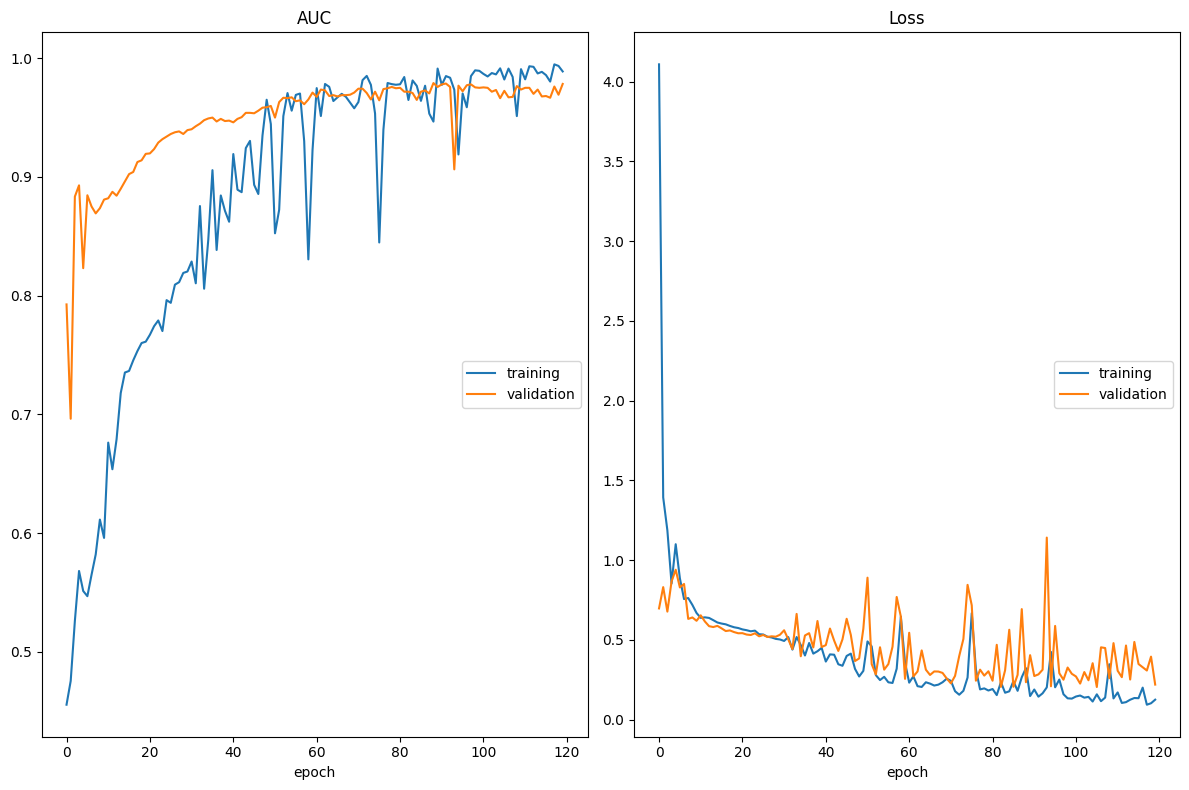

AUC
	training         	 (min:    0.455, max:    0.995, cur:    0.989)
	validation       	 (min:    0.696, max:    0.979, cur:    0.978)
Loss
	training         	 (min:    0.094, max:    4.108, cur:    0.126)
	validation       	 (min:    0.205, max:    1.142, cur:    0.220)
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 228ms/step - AUC: 0.9888 - loss: 0.1326 - val_AUC: 0.9782 - val_loss: 0.2204


In [32]:
monks_model_CNN_ResNet = model_ResNet.fit(
    CNN_ResNet_CE_x, CNN_ResNet_CE_y,
    validation_data=[CNN_ResNet_CV_x, CNN_ResNet_CV_y],
    epochs=120, verbose=1,
    callbacks=[PlotLossesKeras()])

## 8.Cálculo de densidad poblacional por grupos de Frilejones

Iniciaremos con el cálculo total de frilejones en la imagen y con ello (de acuerdo con la ayuda) tendrémos la densidad de frilejones. Para ello únicamente correremos el loop nuevamente y cambiaremos un poco sus parametros para contar el número exacto de frilejones en la imagen.

NOTA: aprovecharemos también para sacar la ubicaciónd de cada frilejon simulando "latitud y longitud". Como se muestra en la siguiente imagen:


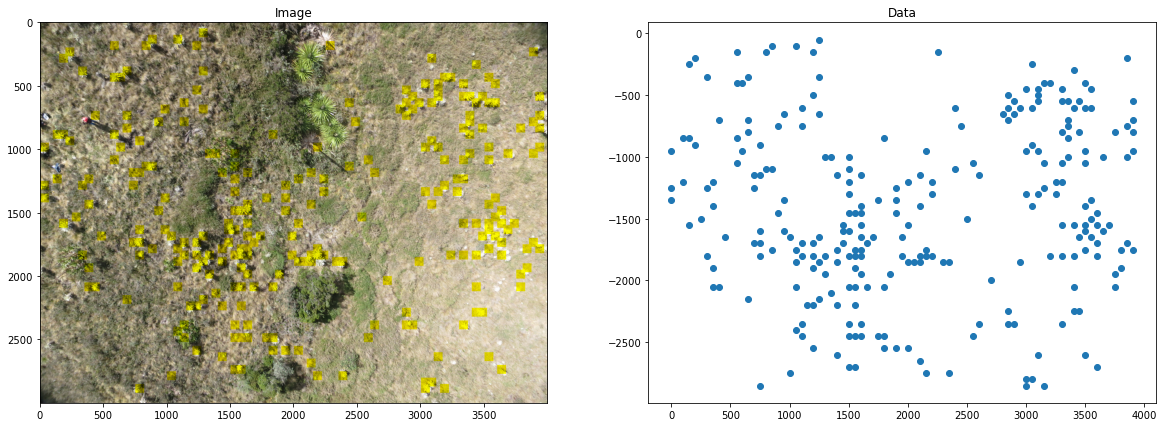


Una vez calculada la cantidad total de frilejones en la imagen, debe hacer el cálculo de la densidad poblacional. Se recomienda el uso de un GMM o puede aplicar algún análisis, heurística que identifique los grupos de frilejosnes en la imagen y la densidad en cada grupo.

In [ ]:
Ver informe CRISP